### Although mAP metric is popular, I think we still need to write a new notebook to compute CV score
1. Most of the mAP calculators are integrated within particular frameworks such as detectron2, yolo, mmdet, etc... It might lack flexibility if we want to ensemble various models.
2. Some standalone codes only compute box-mAP, not segm-mAP

=> So I reimplement the code to compute mAP for this competition. **Note that it only support single class at the moment**. I use my Detectron2 model to make predictions as an example and I also compare with Detectron2 built-in CocoEvaluator

In [1]:
!pip install  -q /kaggle/input/detectron2-wheel/detectron2/detectron2-0.6-cp310-cp310-linux_x86_64.whl --no-index --find-links=/kaggle/input/detectron2-wheel/detectron2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.6.0 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
cuml 23.6.0 requires dask==2023.3.2, but you have dask 2023.6.0 which is incompatible.
dask-cuda 23.6.0 requires dask==2023.3.2, but you have dask 2023.6.0 which is incompatible.
dask-cudf 23.6.0 requires dask==2023.3.2, but you have dask 2023.6.0 which is incompatible.
distributed 2023.3.2.1 requires dask==2023.3.2, but you have dask 2023.6.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.1 which is incompatible.
jupyterlab-lsp 4.2.0 requires jupyter-

In [2]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg, CfgNode
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader, build_detection_test_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances

In [3]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib
import json

## Load model

In [4]:
IMG_DIR = "/kaggle/input/hubmap-hacking-the-human-vasculature/train"
MODEL_PATH = "/kaggle/input/hubmap-v0-v0-val-ds2-wsi1-2/model_0005499.pth"
BLOOD_VESSEL_CLS = 0

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.INPUT.MAX_SIZE_TEST = 1000
cfg.INPUT.MAX_SIZE_TRAIN = 1000
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MIN_SIZE_TRAIN = (512, )

cfg.MODEL.WEIGHTS = MODEL_PATH
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001  # set threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = 'cuda:0'

predictor = DefaultPredictor(cfg)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


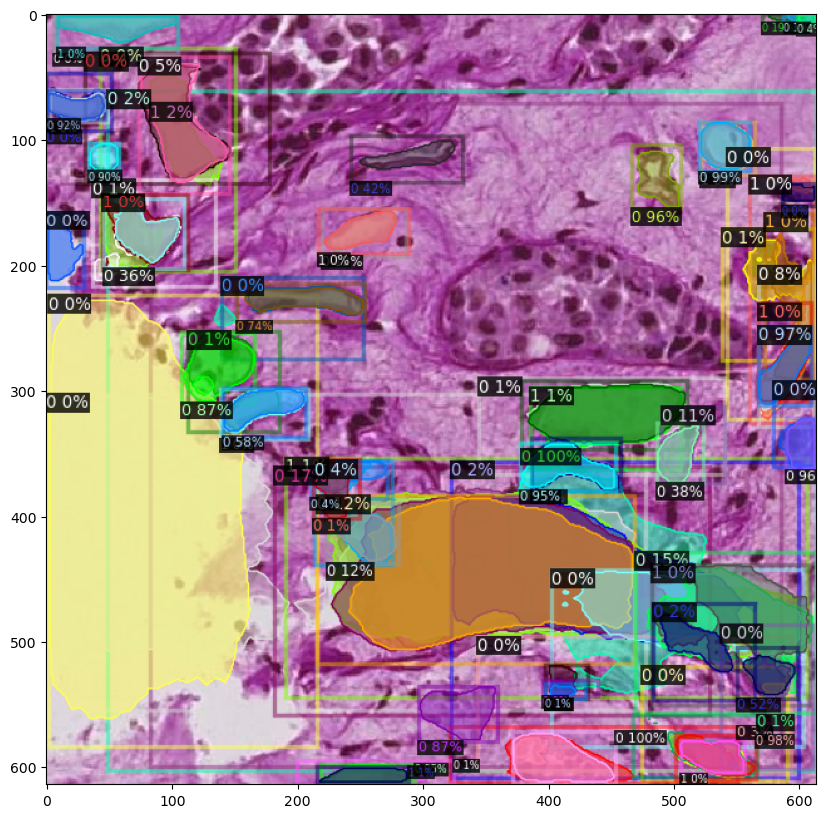

In [6]:
import numpy as np

path = '/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif'
img = cv2.imread(path)
outputs = predictor(img)

plt.figure(figsize = (10,10))


v = Visualizer(img[:,:,::-1], None, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

## segm-mAP code

In [7]:
import pycocotools.mask as mask_util

In [8]:
def predict(predictor, img):
    pred_instances = predictor(img)
    pred_classes = pred_instances['instances'].pred_classes.cpu().numpy()
    keep = pred_classes == BLOOD_VESSEL_CLS
    
    pred_masks = pred_instances['instances'].pred_masks.cpu().numpy()
    pred_masks = pred_masks[keep]
    
    scores = pred_instances['instances'].scores.cpu().numpy()
    scores = scores[keep]
    
    return pred_masks, pred_classes, scores

In [9]:
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


In [10]:
class MAPCalculatorSingleClass:
    def __init__(self, thresholds=[0.6]):
        self.ious = []
        self.confidences = []
        self.image_ids = []
        self.current_img_id = 0
        
        self.GT = 0
        
    def accumulate(self, ious, confidences, num_gt):
        assert len(ious) == len(confidences)
        self.ious.extend([x for x in ious])
        self.confidences.extend(confidences)
        self.image_ids.extend([self.current_img_id]*len(confidences))
        self.current_img_id += 1
        self.GT += num_gt
        
        
    def evaluate(self, thresholds=[0.6], vis=False):        
        # sort by confidence descending
        sorted_inds = np.argsort(self.confidences)[::-1]
        
        results = dict()
        
        for th in thresholds:
            accum_tp = 0
            accum_fp = 0
            
            TP = []
            FP = []
            list_gts = dict()
            
            NPREDS = []
            count = 0
            for ind in sorted_inds:
                iou_row = self.ious[ind]
                img_id = self.image_ids[ind]
                
                matched_inds = np.where(iou_row >= th)[0]
                best_gt_ind = -1
                best_iou = 0
                for gt_ind in matched_inds:
                    iou = iou_row[gt_ind]
                    if iou > best_iou and list_gts.get((img_id, gt_ind)) is None:
                        best_iou = iou
                        best_gt_ind = gt_ind
                
                if best_gt_ind != -1:
                    list_gts[(img_id, best_gt_ind)] = True
                    accum_tp += 1
                else:
                    accum_fp += 1
                    
                count += 1
                NPREDS.append(count)
                    
                TP.append(accum_tp)
                FP.append(accum_fp)
                
            PR = []
            REC = []
            
            for tp, fp in zip(TP, FP):
                pr = tp / (tp+fp)
                rec = tp / self.GT
                PR.append(pr)
                REC.append(rec)
                
            if vis:
                plt.figure()
                plt.plot(REC, PR, '-o', label='precision-recall curve')
                
            ap, mrec, mpre = voc_ap(REC, PR)
            
            if vis:
                plt.plot(mrec, mpre, '--', label='interpolation')
                plt.legend()
                plt.title('Precision recall curve at threshold:'+str(np.round(th, 2)))
                plt.show()
            
            results[th] = ap
    
        return np.mean(list(results.values())), results

## Compare with Detectron2 mAP@0.5:0.95 CocoEvaluator

In [11]:
JSON_ANN = '/kaggle/input/hubmap-json/ds2_wsi2.json'
with open(JSON_ANN, 'r') as f:
    annotations = json.load(f)

In [12]:
annotations['categories'] # in json annotations, class id starts from 1

[{'id': 1, 'name': 'blood_vessel '}, {'id': 2, 'name': 'glomerulus'}]

In [13]:
JSON_BLOOD_VESSEL_CLS = 1

### Our custom code

In [14]:
mAP_calc = MAPCalculatorSingleClass()

for img_meta in tqdm(annotations['images']):
    width, height = img_meta['width'], img_meta['height']
    img_path = os.path.join(IMG_DIR, img_meta['file_name'])
    img = cv2.imread(img_path)
    
    # when calculating IOU using pycocotools.mask, we need to encode both
    # groundtruth and prediction
    
    # make ground truth    
    targs = []
    enc_targs = []
    for ann in annotations['annotations']:
        if ann['image_id'] == img_meta['id'] and ann['category_id'] == JSON_BLOOD_VESSEL_CLS:
            seg = ann['segmentation']
            if type(seg) == list: # if polygon, need to convert to RLE
                seg = coco_mask.frPyObjects(seg, height, width)[0]
            targs.append(seg)
        enc_targs = targs
    num_gts = len(enc_targs)
        
    # make prediction
    pred_masks, pred_classes, scores = predict(predictor, img)
    # pred_masks: list of numpy array shape H*W 
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    
    # calculate iou
    if len(enc_targs) > 0:
        ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    else:
        ious = np.array([[0]]*len(enc_preds))
    
    # acummulate predictions
    mAP_calc.accumulate(ious, scores, num_gts)
    

  0%|          | 0/293 [00:00<?, ?it/s]

In [15]:
mAP, detail_scores = mAP_calc.evaluate(thresholds=np.arange(0.5, 1.0, 0.05))
print('segm-mAP@0.5:0.95 by custom code:', mAP)

segm-mAP@0.5:0.95 by custom code: 0.17770855265874108


In [16]:
ds_name = 'tmp'
register_coco_instances('tmp', {}, JSON_ANN, IMG_DIR)
metadata = MetadataCatalog.get(ds_name)

ds = DatasetCatalog.get(ds_name)

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator(ds_name,  ("segm", ), False, output_dir="./tmp")
val_loader = build_detection_test_loader(cfg, ds_name)

print('segm-mAP@0.5:0.95 by detectron2 CocoEvaluator')
print(inference_on_dataset(predictor.model, val_loader, evaluator))

segm-mAP@0.5:0.95 by detectron2 CocoEvaluator


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=6.68s).
Accumulating evaluation results...
DONE (t=0.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

### Comparision
- Our custom code outputs AP=0.1777 and Detectron2 CocoEvaluator outputs AP-blood_vessel = 0.1791

## Competition metric
- In this competition, the metric is segm-mAP@0.6

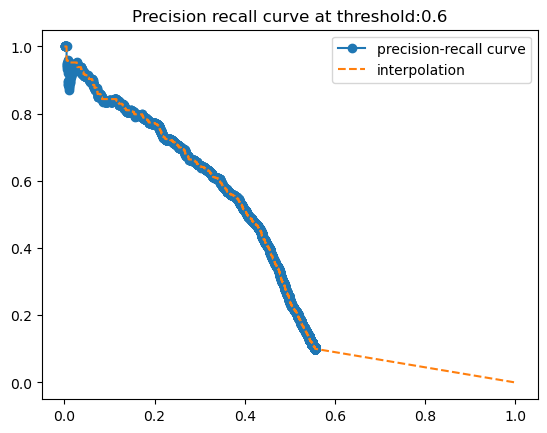

CV (mAP@0.6): 0.35018897693776035


In [18]:
# We test on the above dataset and get the CV score and visualize precision-recall curve
mAP, detail_scores = mAP_calc.evaluate(thresholds=[0.6], vis=True)
print('CV (mAP@0.6):', mAP)

## Make submission 

In [19]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [20]:
test_path = "/kaggle/input/hubmap-hacking-the-human-vasculature/test"
sample_submission = pd.read_csv('/kaggle/input/hubmap-hacking-the-human-vasculature/sample_submission.csv')
ids = []
heights = []
widths = []
prediction_strings = []


for test_name in tqdm(os.listdir(test_path)):
    inp_path = os.path.join(test_path, test_name)
    img = cv2.imread(inp_path)
    h, w, _ = img.shape
    
    pred_masks, pred_classes, scores = predict(predictor, img)
    
   
    pred_string = ""
    for i, mask in enumerate(pred_masks):
        encoded = encode_binary_mask(mask)
        
        if i == 0:
            pred_string += f"{int(pred_classes[i])} {scores[i]} {encoded.decode('utf-8')}"
        else:
            pred_string += f" {int(pred_classes[i])} {scores[i]} {encoded.decode('utf-8')}"
            
    ids.append(test_name.split('.')[0])
    heights.append(h)
    widths.append(w)
    prediction_strings.append(pred_string)
    
#     break

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
sub = pd.DataFrame({'id':ids, 'height':heights, 'width':widths, 
                    'prediction_string':prediction_strings})

In [22]:
sub

,id,height,width,prediction_string
0,72e40acccadf,512,512,0 0.9997168183326721 eNoLjs82STCItzfxMfE19DPyB...


In [23]:
sub.to_csv('submission.csv', index=False)